In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
DIR_KNOWNS = 'knowns'
DIR_UNKNOWNS = 'unknowns'
DIR_RESULTS = 'results'

In [3]:
# Leer mobilenet_graph.pb
with tf.io.gfile.GFile('mobilenet_graph.pb','rb') as f:
    graph_def = tf.compat.v1.GraphDef()
    graph_def.ParseFromString(f.read())

with tf.Graph().as_default() as mobilenet:
    tf.import_graph_def(graph_def,name='')

In [ ]:
print(mobilenet)

In [8]:
def load_image(DIR, NAME):
    return cv2.cvtColor(cv2.imread(f'{DIR}/{NAME}'), cv2.COLOR_BGR2RGB)

In [43]:
def load_image_stable(DIR, NAME):
    # Intentar cargar la imagen con la extensión original
    image_path = os.path.join(DIR, NAME)
    image = cv2.imread(image_path)
    
    # Si la imagen no se carga, intenta cambiar la extensión y cargar de nuevo
    if image is None:
        if ".jpg" in NAME:
            NAME = NAME.replace(".jpg", ".jpeg")
        elif ".jpeg" in NAME:
            NAME = NAME.replace(".jpeg", ".jpg")
        else:
            raise ValueError(f"Unsupported file extension in {NAME}.")
        
        image_path = os.path.join(DIR, NAME)
        image = cv2.imread(image_path)

    # Si aún así la imagen no se carga, lanza un error
    if image is None:
        raise ValueError(f"Failed to load image at {image_path}.")
    
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [42]:
def convert_jpeg_to_jpg(jpeg_path):
    image = cv2.imread(jpeg_path)
    if image is None:
        raise ValueError(f"Failed to load .jpeg image at {jpeg_path}.")
    
    jpg_path = jpeg_path[:-4] + "jpg"  # Change .jpeg to .jpg
    cv2.imwrite(jpg_path, image)


In [5]:
def detect_faces(image, score_threshold=0.7):
    global boxes, scores
    (imh, imw) = image.shape[:-1]
    img = np.expand_dims(image,axis=0)
    
    # Inicializar mobilenet
    sess = tf.compat.v1.Session(graph=mobilenet)
    image_tensor = mobilenet.get_tensor_by_name('image_tensor:0')
    boxes = mobilenet.get_tensor_by_name('detection_boxes:0')
    scores = mobilenet.get_tensor_by_name('detection_scores:0')
    
    # Predicción (detección)
    (boxes, scores) = sess.run([boxes, scores], feed_dict={image_tensor:img})
    
    # Reajustar tamaños boxes, scores
    boxes = np.squeeze(boxes,axis=0)
    scores = np.squeeze(scores,axis=0)
    
    # Depurar bounding boxes
    idx = np.where(scores>=score_threshold)[0]
    
    # Crear bounding boxes
    bboxes = []
    for index in idx:
        ymin, xmin, ymax, xmax = boxes[index,:]
        (left, right, top, bottom) = (xmin*imw, xmax*imw, ymin*imh, ymax*imh)
        left, right, top, bottom = int(left), int(right), int(top), int(bottom)
        bboxes.append([left,right,top,bottom])
        
    return bboxes

In [6]:
def draw_box(image,box,color,line_width=6):
    if box==[]:
        return image
    else:
        cv2.rectangle(image,(box[0],box[2]),(box[1],box[3]),color,line_width)
    return image

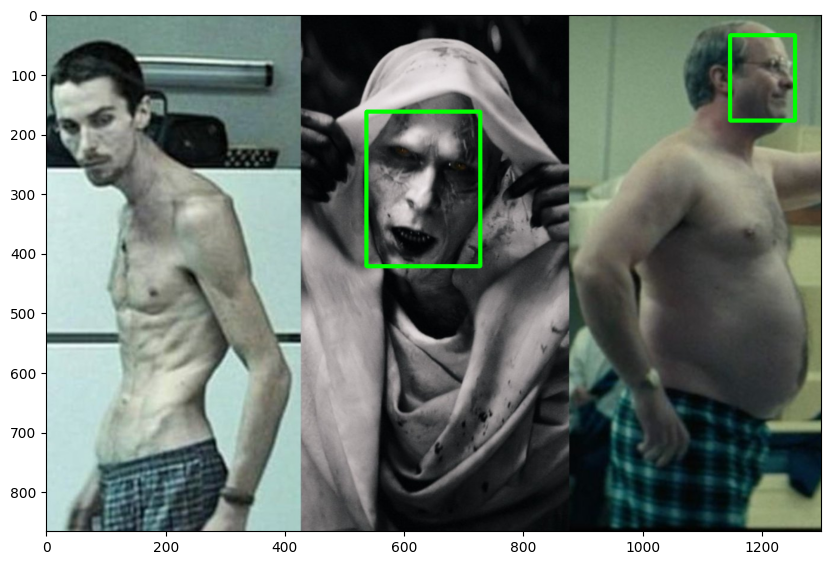

In [7]:
name = 'christian_bale_01.jpg'
image = load_image(DIR_UNKNOWNS,name)
bboxes = detect_faces(image)
for box in bboxes:
    detected_faces = draw_box(image,box,(0,255,0))
fig = plt.figure(figsize=(10,10))
plt.imshow(detected_faces)

In [8]:
# Extraer rostros
def extract_faces(image,bboxes,new_size=(160,160)):
    cropped_faces = []
    for box in bboxes:
        left, right, top, bottom = box
        face = image[top:bottom,left:right]
        cropped_faces.append(cv2.resize(face,dsize=new_size))
    return cropped_faces

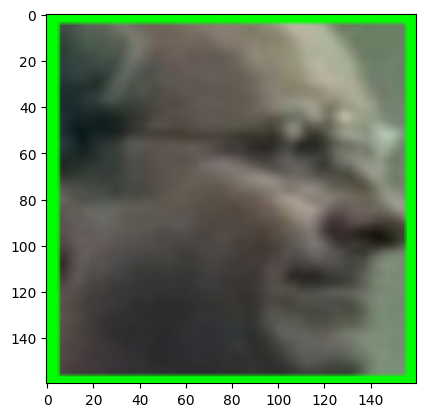

In [9]:
faces = extract_faces(image,bboxes)
plt.imshow(faces[1])

In [ ]:
def compute_embedding(model,face):
    face = face.astype('float32')
    
    mean, std = face.mean(), face.std()
    face = (face-mean) / std
    
    face = np.expand_dims(face,axis=0)
    
    embedding = model.predict(face)
    return embedding

In [20]:
from keras_facenet import FaceNet


In [21]:
embedder = FaceNet()

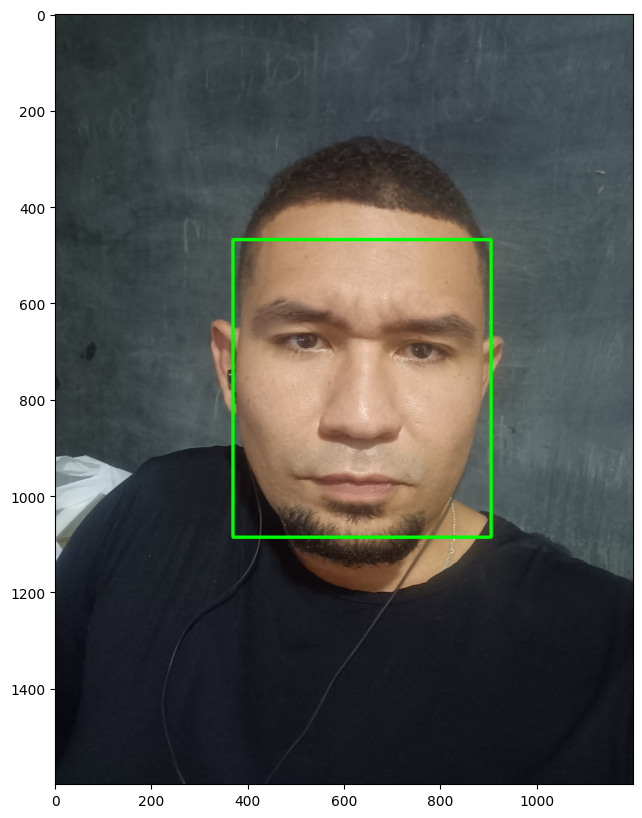

In [13]:
name_1 = 'cara_a_reconocer.jpg'
image_ref = load_image(DIR_KNOWNS,name_1)
bboxes = detect_faces(image_ref)
for box in bboxes:
    detected_faces = draw_box(image_ref,box,(0,255,0))
fig = plt.figure(figsize=(10,10))
plt.imshow(detected_faces)

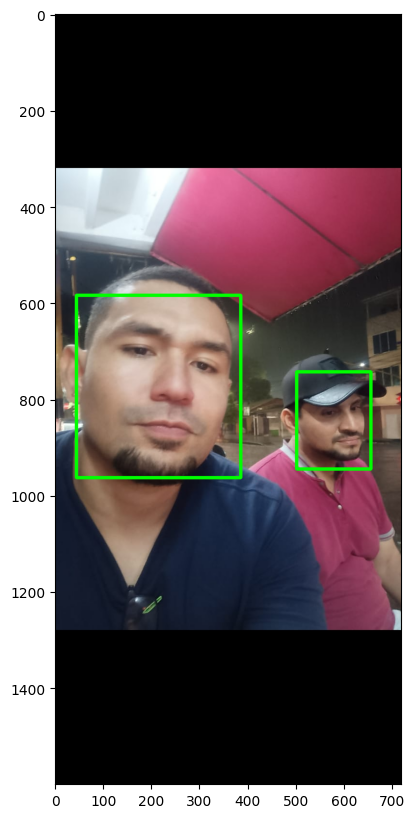

In [15]:
name_2 = 'prueba_3.jpg'
image_to = load_image(DIR_UNKNOWNS,name_2)
bboxes = detect_faces(image_to)
for box in bboxes:
    detected_faces = draw_box(image_to,box,(0,255,0))
fig = plt.figure(figsize=(10,10))
plt.imshow(detected_faces)

In [17]:
def get_embedding(image_path):
    # Carga la imagen
    image = load_image(image_path)
    
    # Detecta las caras en la imagen
    bboxes = detect_faces(image)
    
    # Si no se detectan caras, retorna None
    if not bboxes:
        return None

    # Extrae la cara de la imagen (asumiendo una única cara por imagen para simplificar)
    left, right, top, bottom = bboxes[0]
    face = image[top:bottom, left:right]

    # Obtiene la embedding para la cara
    embedding = embedder.embeddings([face])
    
    return embedding[0]

# 3. Función para calcular la distancia entre dos embeddings
def calculate_distance(embedding1, embedding2):
    return np.linalg.norm(embedding1 - embedding2)

1/1 [==============================] - 0s 64ms/step
Distancia  1.0290489
1/1 [==============================] - 0s 64ms/step
Distancia  1.1883578
1/1 [==============================] - 0s 62ms/step
Distancia  1.3062423


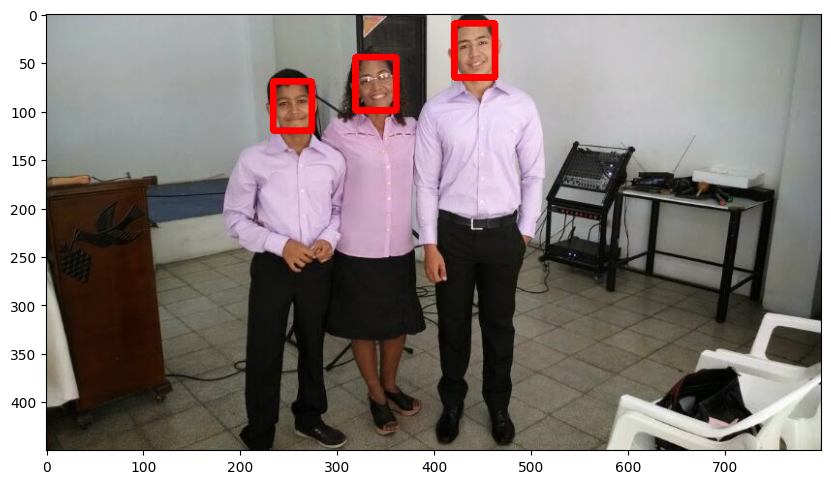

In [30]:
# Función para obtener embeddings de una imagen
def get_embedding_from_face(face):
    # Asume que face ya es una región de la imagen que representa una cara
    embedding = embedder.embeddings([face])
    return embedding[0]

# 1. Carga la imagen de referencia y obtiene su embedding
ref_image_path = 'cara_a_reconocer.jpg'
ref_image = load_image(DIR_KNOWNS, ref_image_path)
ref_bboxes = detect_faces(ref_image)
if not ref_bboxes:
    print("No faces detected in reference image.")
    exit()

# Extrae la cara de la imagen de referencia (asumiendo una única cara por imagen para simplificar)
left, right, top, bottom = ref_bboxes[0]
ref_face = ref_image[top:bottom, left:right]
ref_embedding = get_embedding_from_face(ref_face)

# 2. Para cada cara detectada en la imagen a probar
name = 'prueba_5.jpg'
image = load_image(DIR_UNKNOWNS, name)
bboxes = detect_faces(image)
for box in bboxes:
    left, right, top, bottom = box
    face = image[top:bottom, left:right]
    face_embedding = get_embedding_from_face(face)

    # Calcula la distancia con la imagen de referencia
    distance = calculate_distance(ref_embedding, face_embedding)
    print('Distancia ',distance)
    # 3. Si la distancia es menor que un umbral, pinta el cuadro en verde, de lo contrario en rojo.
    threshold = 0.7  # Este valor puede necesitar ajuste
    if distance < threshold:
        color = (0, 255, 0)  # Verde
    else:
        color = (255, 0, 0)  # Rojo

    detected_faces = draw_box(image, box, color)

fig = plt.figure(figsize=(10, 10))
plt.imshow(detected_faces)

1/1 [==============================] - 0s 66ms/step
Distancia  0.8562864


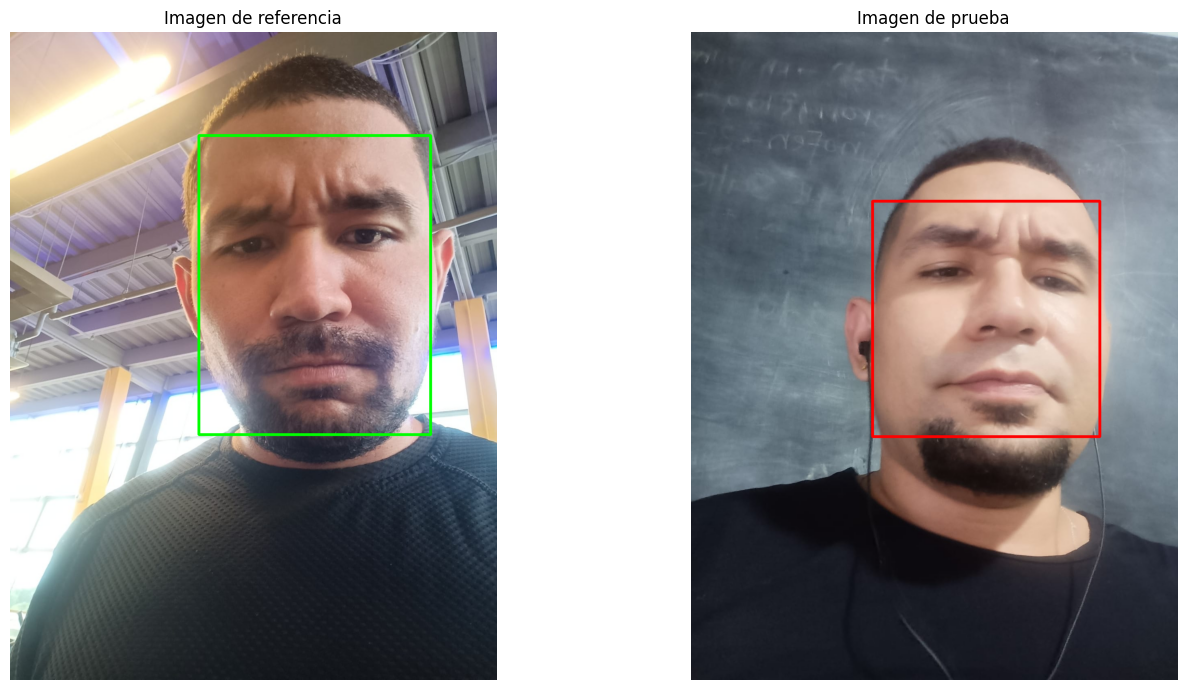

In [45]:

# Función para obtener embeddings de una imagen
def get_embedding_from_face(face):
    # Asume que face ya es una región de la imagen que representa una cara
    embedding = embedder.embeddings([face])
    return embedding[0]

# 1. Carga la imagen de referencia y obtiene su embedding
ref_image_path = 'prueba_1.jpg'
ref_image = load_image_stable(DIR_KNOWNS, ref_image_path)
ref_bboxes = detect_faces(ref_image)
if not ref_bboxes:
    print("No faces detected in reference image.")
    exit()

# Extrae la cara de la imagen de referencia (asumiendo una única cara por imagen para simplificar)
left, right, top, bottom = ref_bboxes[0]
ref_face = ref_image[top:bottom, left:right]
ref_embedding = get_embedding_from_face(ref_face)

# Dibuja el cuadro alrededor de la cara de referencia
ref_image = draw_box(ref_image, [left, right, top, bottom], (0, 255, 0))

# 2. Para cada cara detectada en la imagen a probar
name = 'prueba_9.jpg'
image = load_image_stable(DIR_UNKNOWNS, name)
bboxes = detect_faces(image)
for box in bboxes:
    left, right, top, bottom = box
    face = image[top:bottom, left:right]
    face_embedding = get_embedding_from_face(face)

    # Calcula la distancia con la imagen de referencia
    distance = calculate_distance(ref_embedding, face_embedding)
    print('Distancia ',distance)
    
    # 3. Si la distancia es menor que un umbral, pinta el cuadro en verde, de lo contrario en rojo.
    threshold = 0.7  # Este valor puede necesitar ajuste
    if distance < threshold:
        color = (0, 255, 0)  # Verde
    else:
        color = (255, 0, 0)  # Rojo

    detected_faces = draw_box(image, box, color)

# Muestra las imágenes una al lado de la otra
fig, ax = plt.subplots(1, 2, figsize=(15, 7))  # Dos subplots en una fila y dos columnas

ax[0].imshow(ref_image)
ax[0].set_title("Imagen de referencia")
ax[0].axis("off")

ax[1].imshow(detected_faces)
ax[1].set_title("Imagen de prueba")
ax[1].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
Hay varias maneras de manejar imágenes múltiples de la misma persona en una base de datos de reconocimiento facial. Aquí hay algunas estrategias y cómo implementarlas:

Promedio de Embeddings:

Calcula los embeddings para cada imagen conocida y luego toma el promedio de todos los embeddings. Usa este embedding promedio para comparaciones.
Votación:

Compara la imagen desconocida con cada imagen conocida. Si la mayoría de las imágenes conocidas están por debajo del umbral de distancia, entonces considera que la imagen desconocida es una coincidencia.
Umbral Dinámico:

Calcula la distancia para cada imagen conocida y luego usa un umbral dinámico basado en la media y desviación estándar de esas distancias.

1/1 [==============================] - 0s 66ms/step
Distancia  1.201303
1/1 [==============================] - 0s 66ms/step
Distancia  1.2365179
1/1 [==============================] - 0s 58ms/step
Distancia  0.7052639
1/1 [==============================] - 0s 76ms/step
Distancia  1.0004348


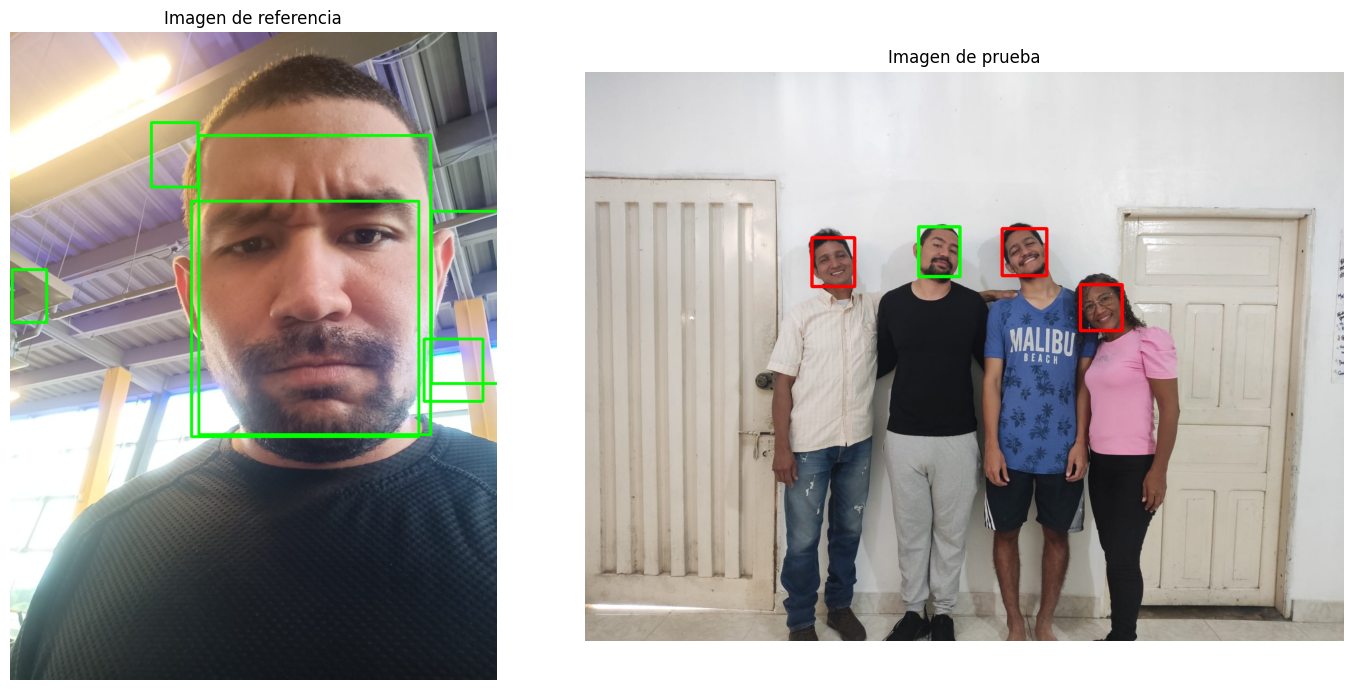

In [58]:
def get_average_embedding(image_paths):
    """Obtiene el embedding promedio de una lista de imágenes."""
    embeddings = []
    for path in image_paths:
        img = load_image(DIR_KNOWNS, path)
        bboxes = detect_faces(img)
        if bboxes:
            left, right, top, bottom = bboxes[0]
            face = img[top:bottom, left:right]
            embeddings.append(get_embedding_from_face(face))
    
    average_embedding = np.mean(embeddings, axis=0)
    return average_embedding

# 1. Obtener el embedding promedio de todas las imágenes conocidas
known_images = os.listdir(DIR_KNOWNS)
ref_embedding = get_average_embedding(known_images)


# Dibuja el cuadro alrededor de la cara de referencia
ref_image = draw_box(ref_image, [left, right, top, bottom], (0, 255, 0))

# 2. Para cada cara detectada en la imagen a probar
name = 'test_8.jpg'
image = load_image_stable(DIR_UNKNOWNS, name)
bboxes = detect_faces(image)
for box in bboxes:
    left, right, top, bottom = box
    face = image[top:bottom, left:right]
    face_embedding = get_embedding_from_face(face)

    # Calcula la distancia con la imagen de referencia
    distance = calculate_distance(ref_embedding, face_embedding)
    print('Distancia ',distance)
    
    # 3. Si la distancia es menor que un umbral, pinta el cuadro en verde, de lo contrario en rojo.
    threshold = 0.9  # Este valor puede necesitar ajuste
    if distance < threshold:
        color = (0, 255, 0)  # Verde
    else:
        color = (255, 0, 0)  # Rojo

    detected_faces = draw_box(image, box, color)

# Muestra las imágenes una al lado de la otra
fig, ax = plt.subplots(1, 2, figsize=(15, 7))  # Dos subplots en una fila y dos columnas

ax[0].imshow(ref_image)
ax[0].set_title("Imagen de referencia")
ax[0].axis("off")

ax[1].imshow(detected_faces)
ax[1].set_title("Imagen de prueba")
ax[1].axis("off")

plt.tight_layout()
plt.show()